In [6]:
import matplotlib.pyplot as plt
import numpy as np
import sys

import engage_geophires_client
import engage_parametrization_visualization

import importlib
importlib.reload(engage_geophires_client)
importlib.reload(engage_parametrization_visualization)

from engage_geophires_client import *
from engage_parametrization_visualization import *

## Notes
-  Flag error if the reservoir heat content is depleted before the project lifetime
-  EGS gradient sections need to be reviewed if there is more than one gradient
-  User should use only one value for all or define all four. If user has 50 gradient 1 and 75 gradient 2, 75 should be assigned to the 3 and 4
- Flash steam power plants are relatively a common method used to convert the geothermal energy into electricity when production wells produce a mixture of steam and liquid in a geothermal system. In comparison to the single flash system, the double flash steam power plant generates more power from geothermal fluid at the same conditions. However, electricity generation costs are higher for double flash plants. A thermoeconomic optimization model is presented in this paper as the generation costs of single and double flash steam power plants. By considering the pressures in the separator and flash vessel (only in a double flash plant) as the independent variables in the objective function and using numerical search methods (Golden Ratio and Nelder-Mead ), the minimum power generation cost was calculated at different geofluid conditions for either single or double flash steam power plants.
- Might need to implement a time-varying efficiency of the chiller based on yearly ambient temperature
- Flag Flash is only suitable after this depth (specify depth)
- Add injection temperature as an input to the engage user 
- Lifetime should be an input not an output
- Flash systems tell user to keep prod temperature target above 200
- We need to set up degradation into the technology to address how a technology performs over time

In [7]:
def generate_parameters(base_params, depth_range, flow_rate_range, wells_prod_range, wells_inj_range, prod_diam, inj_diam,cost_correlation):
    parameter_list = []
    depth_start, depth_stop, depth_step = depth_range
    flow_rate_start, flow_rate_stop, flow_rate_step = flow_rate_range
    wells_prod_start, wells_prod_stop = wells_prod_range  # Assuming step is 1
    wells_inj_start, wells_inj_stop = wells_inj_range    # Assuming step is 1

    for depth in np.arange(depth_start, depth_stop, depth_step):
        for flow_rate in range(flow_rate_start, flow_rate_stop, flow_rate_step):
            for wells_prod in range(wells_prod_start, wells_prod_stop + 1):
                for wells_inj in range(wells_inj_start, wells_inj_stop + 1):
                    if wells_inj < wells_prod:
                        continue

                    # Create a copy of the base parameters and update specific values
                    params = base_params.copy()
                    params.update({
                        # 'Power Plant Type': plant_type,  # Uncomment if plant_type is to be used
                        'Production Flow Rate per Well': flow_rate,
                        'Reservoir Depth': depth,
                        'Number of Production Wells': wells_prod,
                        'Number of Injection Wells': wells_inj,
                        'Production Well Diameter': prod_diam,
                        'Injection Well Diameter': inj_diam,
                        'Well Drilling Cost Correlation': cost_correlation,
                    })
                    parameter_list.append(params)
    return parameter_list

In [8]:
#============================================================================================
#============================================INPUTS==========================================
#============================================================================================

environment     = 'HYDRO'  # HYDRO OR EGS
technology      = 'binary_orc' #chp, binary_orc, double_flash, direct_use

target_prod_temp_min   = 150
target_prod_temp_max   = 200

prod_well_diam = 8.5
inj_well_diam = 8.5

well_cost_correlation = 10

# Define variables for ranges and steps
depth_start = 1
depth_stop = 5
depth_step = 0.2

flow_rate_start = 50
flow_rate_stop = 150
flow_rate_step = 50

wells_prod_start = 1
wells_prod_stop = 4

wells_inj_start = 1
wells_inj_stop = 4
#============================================================================================
#============================================================================================


plant           = f'{environment}_{technology}'

# Define base parameters for each technology#
base_params = {
    'HYDRO_chp': {
       'Reservoir Model': 4,
       'Drawdown Parameter': 0.003,
       'Number of Segments': 4,
       'Gradient 1':70,
       'Thickness 1':1,
       'Gradient 2':70,
       'Thickness 2':1,
       'Gradient 3':70,
       'Thickness 3':1,
       'Gradient 4':70,
       'Maximum Temperature': 400,
       'Ramey Production Wellbore Model': 0,
       'Production Wellbore Temperature Drop': 5,
       'Injection Wellbore Temperature Gain': 3,
       'Reservoir Volume Option': 1,
       'Injectivity Index': 5,
       'Injection Temperature': 50,
       'Maximum Drawdown': 1,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'Water Loss Fraction': 0.02,
       'End-Use Option': 31,
       'Power Plant Type': 1,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Print Output to Console': 0
   },
    'EGS_chp': {
       'Reservoir Model':3,
       'Drawdown Parameter': 0.00002,
       'Number of Segments': 4,
       'Gradient 1':55,
       'Thickness 1':1,
       'Gradient 2':55,
       'Thickness 2':1,
       'Gradient 3':55,
       'Thickness 3':1,
       'Gradient 4':55,
       'Maximum Temperature': 400,
       'Injection Temperature': 50,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'End-Use Option': 31,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Fracture Shape': 3,                   
       'Fracture Height': 600,
       'Number of Fractures':20,               
       'Reservoir Volume Option': 1,
       'Power Plant Type': 1,
       'Print Output to Console': 0
   },
    'HYDRO_binary_orc': {
       'Reservoir Model': 4,
       'Drawdown Parameter': 0.003,
       'Number of Segments': 1,    
       'Gradient 1': 70,
       'Ramey Production Wellbore Model': 0,
       'Production Wellbore Temperature Drop': 0,
       'Injection Wellbore Temperature Gain': 0,
       'Maximum Temperature': 400,
       'Reservoir Volume Option': 4,
       'Reservoir Volume': 1e9,
       'Water Loss Fraction': 0.0,
       'Injectivity Index': 10,
       'Productivity Index': 10,
       'Injection Temperature': 70,
       'Maximum Drawdown': 1,
       'Reservoir Heat Capacity': 1050,
       'Reservoir Density': 2700,
       'Reservoir Thermal Conductivity': 3,
       'End-Use Option': 1,
       'Power Plant Type': 1,
       'Circulation Pump Efficiency': 0.8,
       'Utilization Factor': 0.9,
       'Surface Temperature': 15,
       'Ambient Temperature': 15,
       'Plant Lifetime': 30,
       'Print Output to Console': 0,
   },
    'EGS_binary_orc': {
       'Reservoir Model':3,
       'Drawdown Parameter': 0.00002,
       'Number of Segments': 4,
       'Gradient 1':55,
       'Thickness 1':1,
       'Gradient 2':55,
       'Thickness 2':1,
       'Gradient 3':55,
       'Thickness 3':1,
       'Gradient 4':55,
       'Maximum Temperature': 400,
       'Injection Temperature': 70,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'End-Use Option': 1,
       'Power Plant Type': 1,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Fracture Shape': 3,                   
       'Fracture Height': 600,
       'Number of Fractures':20,               
       'Reservoir Volume Option': 1,
       'Print Output to Console': 0
   },
    'EGS_direct_use': {
       'Reservoir Model': 1,
       'Number of Segments': 4,
       'Gradient 1':30,
       'Thickness 1':1,
       'Gradient 2':30,
       'Thickness 2':1,
       'Gradient 3':30,
       'Thickness 3':1,
       'Gradient 4':30,
       'Ramey Production Wellbore Model': 1,
       'Injection Wellbore Temperature Gain': 0,
       'Fracture Shape': 3,
       'Fracture Height': 700,
       'Maximum Temperature': 400,
       'Reservoir Volume Option': 1,
       'Fracture Separation': 100,
       'Reservoir Impedance': 0.05,
       'Injection Temperature': 40,
       'Maximum Drawdown': 0.3,
       'Reservoir Heat Capacity': 975,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3.2,
       'End-Use Option': 2,
       'Circulation Pump Efficiency': 0.8,
       'End-Use Efficiency Factor': 0.9,
       'Surface Temperature': 20,
       'Ambient Temperature': 20,
       'Plant Lifetime': 30,
       'Power Plant Type': 1,
       'Print Output to Console': 0
   },
    'HYDRO_direct_use': {
       'Reservoir Model': 4,
       'Drawdown Parameter': 0.003,
       'Number of Segments': 4,
       'Gradient 1':50,
       'Thickness 1':1,
       'Gradient 2':50,
       'Thickness 2':1,
       'Gradient 3':50,
       'Thickness 3':1,
       'Gradient 4':50,
       'Maximum Temperature': 400,
       'Ramey Production Wellbore Model': 0,
       'Production Wellbore Temperature Drop': 5,
       'Injection Wellbore Temperature Gain': 3,
       'Reservoir Volume Option': 1,
       'Injectivity Index': 5,
       'Injection Temperature': 40,
       'Maximum Drawdown': 1,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'Water Loss Fraction': 0.02,
       'End-Use Option': 2,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Power Plant Type': 1,
       'Print Output to Console': 0
   },
    'HYDRO_double_flash': {
       'Reservoir Model': 4,
       'Drawdown Parameter': 0.003,
       'Number of Segments': 4,
       'Gradient 1':75,
       'Thickness 1':1,
       'Gradient 2':75,
       'Thickness 2':1,
       'Gradient 3':75,
       'Thickness 3':1,
       'Gradient 4':75,
       'Maximum Temperature': 400,
       'Ramey Production Wellbore Model': 0,
       'Production Wellbore Temperature Drop': 5,
       'Injection Wellbore Temperature Gain': 3,
       'Reservoir Volume Option': 1,
       'Injectivity Index': 5,
       'Injection Temperature': 70,
       'Maximum Drawdown': 1,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'Water Loss Fraction': 0.02,
       'End-Use Option': 1,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Power Plant Type': 4,
       'Print Output to Console': 0
},
    'EGS_double_flash': {
       'Reservoir Model':3,
       'Drawdown Parameter': 0.00002,
       'Number of Segments': 4,
       'Gradient 1':75,
       'Thickness 1':1,
       'Gradient 2':75,
       'Thickness 2':1,
       'Gradient 3':75,
       'Thickness 3':1,
       'Gradient 4':75,
       'Maximum Temperature': 400,
       'Injection Temperature': 70,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'End-Use Option': 1,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Fracture Shape': 3,                   
       'Fracture Height': 600,
       'Number of Fractures':20,               
       'Reservoir Volume Option': 1,
       'Power Plant Type': 4,
       'Print Output to Console': 0
   },
    'HYDRO_cchp': {
       'Reservoir Model': 4,
       'Drawdown Parameter': 0.003,
       'Number of Segments': 4,
       'Gradient 1':70,
       'Thickness 1':1,
       'Gradient 2':70,
       'Thickness 2':1,
       'Gradient 3':70,
       'Thickness 3':1,
       'Gradient 4':70,
       'Maximum Temperature': 400,
       'Ramey Production Wellbore Model': 0,
       'Production Wellbore Temperature Drop': 5,
       'Injection Wellbore Temperature Gain': 3,
       'Reservoir Volume Option': 1,
       'Injectivity Index': 5,
       'Injection Temperature': 40,
       'Maximum Drawdown': 1,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'Water Loss Fraction': 0.02,
       'End-Use Option': 31,
       'Power Plant Type': 1,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Print Output to Console': 0
   },
    'EGS_cchp': {
       'Reservoir Model':3,
       'Drawdown Parameter': 0.00002,
       'Number of Segments': 4,
       'Gradient 1':55,
       'Thickness 1':1,
       'Gradient 2':55,
       'Thickness 2':1,
       'Gradient 3':55,
       'Thickness 3':1,
       'Gradient 4':55,
       'Maximum Temperature': 400,
       'Injection Temperature': 40,
       'Reservoir Heat Capacity': 1000,
       'Reservoir Density': 3000,
       'Reservoir Thermal Conductivity': 3,
       'End-Use Option': 31,
       'Circulation Pump Efficiency': 0.80,
       'Plant Lifetime': 30,
       'Fracture Shape': 3,                   
       'Fracture Height': 600,
       'Number of Fractures':20,               
       'Reservoir Volume Option': 1,
       'Power Plant Type': 1,
       'Print Output to Console': 0
   }
}

# Update the technology_to_function dictionary to include the new naming
technology_to_function = {
    'EGS_chp': generate_parameters,
    'HYDRO_chp': generate_parameters,
    'HYDRO_binary_orc': generate_parameters,
    'EGS_binary_orc': generate_parameters,
    'HYDRO_double_flash': generate_parameters,
    'EGS_double_flash': generate_parameters,
    'HYDRO_direct_use': generate_parameters,
    'EGS_direct_use': generate_parameters,
    'EGS_cchp': generate_parameters,
    'HYDRO_cchp': generate_parameters,
}

# Define the ranges outside the dictionary definition
depth_range = (depth_start, depth_stop, depth_step)
flow_rate_range = (flow_rate_start, flow_rate_stop, flow_rate_step)
wells_prod_range = (wells_prod_start, wells_prod_stop)  # Implicit step of 1
wells_inj_range = (wells_inj_start, wells_inj_stop)    # Implicit step of 1

# Generate parameters based on the selected technology and environment
if plant in technology_to_function and plant in base_params:
    generated_parameters = technology_to_function[plant](base_params[plant],depth_range,
                                                         flow_rate_range,wells_prod_range,wells_inj_range, 
                                                         prod_well_diam, inj_well_diam, well_cost_correlation)  
    
    # Assume EngageAnalysis is a previously defined class for analysis
    engage_analysis = geophires_parametrization_analysis(plant,target_prod_temp_min, target_prod_temp_max)

    # Prepare parameters for analysis (Assuming this method is defined in EngageAnalysis)
    engage_analysis.prepare_parameters(generated_parameters)

    print(f"============System Configured for {environment}-{technology} Plant=================\n")
    print(generated_parameters[0])
    print(f"\n===================================================================================")
else:
    print(f"Combination '{plant}' is not supported.")


============System Configured for EGS-chp Plant=================

{'Reservoir Model': 3, 'Drawdown Parameter': 2e-05, 'Number of Segments': 4, 'Gradient 1': 55, 'Thickness 1': 1, 'Gradient 2': 55, 'Thickness 2': 1, 'Gradient 3': 55, 'Thickness 3': 1, 'Gradient 4': 55, 'Maximum Temperature': 400, 'Injection Temperature': 50, 'Reservoir Heat Capacity': 1000, 'Reservoir Density': 3000, 'Reservoir Thermal Conductivity': 3, 'End-Use Option': 31, 'Circulation Pump Efficiency': 0.8, 'Plant Lifetime': 30, 'Fracture Shape': 3, 'Fracture Height': 600, 'Number of Fractures': 20, 'Reservoir Volume Option': 1, 'Power Plant Type': 1, 'Print Output to Console': 0, 'Production Flow Rate per Well': 50, 'Reservoir Depth': 1.0, 'Number of Production Wells': 1, 'Number of Injection Wells': 1, 'Production Well Diameter': 8.5, 'Injection Well Diameter': 8.5, 'Well Drilling Cost Correlation': 10}



In [9]:
# # Run iterations and process the data
engage_analysis.run_iterations()

[2024-03-05 16:01:52][WARNING] Parameter given (400.0) for Maximum Temperature is being set by the input file to a value that is the same as the default. No change was made to that value. Recommendation: remove the Maximum Temperature from the input file unless you wish to change it from the default value of (400.0)
[2024-03-05 16:01:52][WARNING] Parameter given (1000.0) for Reservoir Heat Capacity is being set by the input file to a value that is the same as the default. No change was made to that value. Recommendation: remove the Reservoir Heat Capacity from the input file unless you wish to change it from the default value of (1000.0)
[2024-03-05 16:01:52][WARNING] Parameter given (3.0) for Reservoir Thermal Conductivity is being set by the input file to a value that is the same as the default. No change was made to that value. Recommendation: remove the Reservoir Thermal Conductivity from the input file unless you wish to change it from the default value of (3.0)
[2024-03-05 16:01:

In [10]:
df_final = engage_analysis.get_final_dataframe()
# Remove rows where any of the values are negative
df_final = df_final[(df_final >= 0).all(axis=1)]
# Check if the dataframe is empty after filtering
if df_final.empty:
    print("============================================================================================")
    print("Consider revising the target temperature range, as achieving the specified temperatures may not be feasible with ", plant)
    print("============================================================================================")
    sys.exit("Stopping execution because df_final is empty.")

# Sorting and saving to Excel
df_final = df_final.sort_values(
    by=['Depth (km)', 'Number of Prod Wells', 'Number of Inj Wells'], ascending=[True, True, True]
)
df_final.to_csv(f'results/{plant}_results.csv')

df_final.head()

,Depth (km),Number of Prod Wells,Number of Inj Wells,Flow Rate per Prod Well (kg/sec),Maximum Reservoir Temperature (deg.C),Surface Plant Cost ($M),Exploration Cost ($M),Drilling and completion cost ($MUSD),Wellfield maintenance costs ($MUSD/yr),Make-Up Water O&M Cost ($MUSD/year),...,Average Electricity Production (MWe),Lifetime,Total capital costs ($MUSD/yr),Surface maintenance costs ($MUSD/yr),Average Production Temperature (degC),Maximum Total Electricity Generation (MWe),Maximum Net Heat Production (MWth),Ratio Avg Reservoir Heat Extraction to Ratio Avg Reservoir Heat Extraction,Ratio Avg Heat Production to Avg Reservoir Heat Extraction,Ratio Avg Electricity Production to Avg Reservoir Heat Extraction
0,2.6,1,1,50.0,400.0,9.98,3.89,7.07,0.24,0.0,...,0.01,30,22.46,0.58,152.0,1.77,4.84,1.0,0.231214,0.000482
1,2.6,1,2,50.0,400.0,10.47,3.89,10.61,0.28,0.0,...,0.01,30,27.99,0.58,152.0,1.77,4.84,1.0,0.231214,0.000482
2,2.6,1,3,50.0,400.0,10.95,3.89,14.15,0.32,0.0,...,0.01,30,33.52,0.58,152.0,1.77,4.84,1.0,0.231214,0.000482
3,2.6,1,4,50.0,400.0,11.43,3.89,17.69,0.36,0.0,...,0.01,30,39.05,0.58,152.0,1.77,4.84,1.0,0.231214,0.000482
4,2.6,1,5,50.0,400.0,11.91,3.89,21.22,0.40,0.0,...,0.01,30,44.58,0.58,152.0,1.77,4.84,1.0,0.231214,0.000482


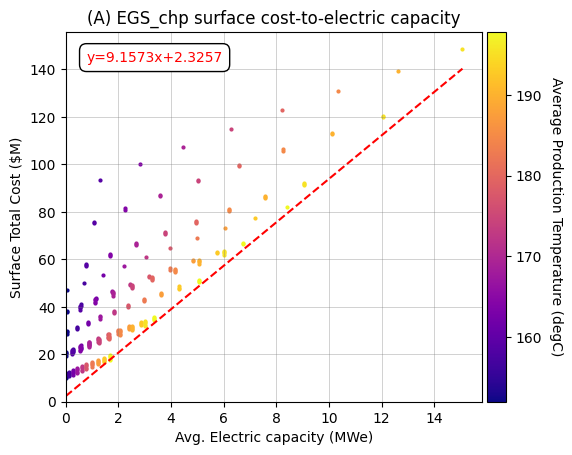

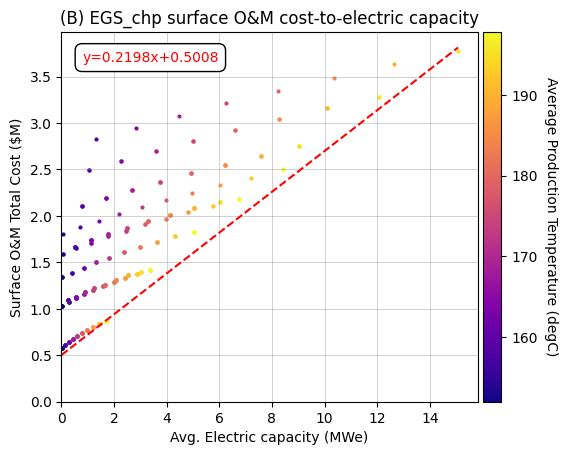

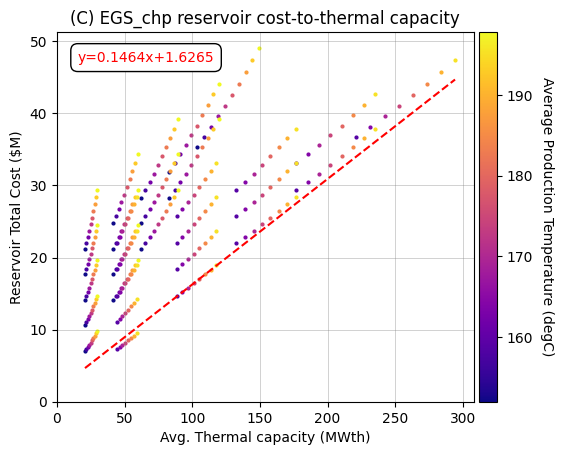

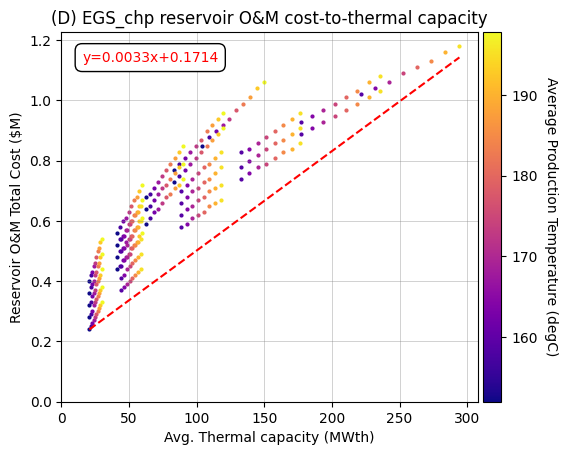

In [11]:
# Function to safely extract a column as an array, or fill with zeros if not present
def safe_extract(df, column_name):
    if column_name in df.columns:
        return np.array(df[column_name])
    else:
        print(f"'{column_name}' not found in DataFrame. Filling with zeros.")
        return np.zeros(len(df))

# Prepare data for plots
cmap = plt.get_cmap('plasma')
unique_prod_wells = df_final['Number of Prod Wells'].unique()
unique_inj_wells = df_final['Number of Inj Wells'].unique()
unique_depth = df_final['Depth (km)'].unique()
unique_temp = df_final['Average Production Temperature (degC)'].unique()

# Safe extraction of columns
heating_capacity = safe_extract(df_final, 'Average Heat Production (MWth)')
electric_capacity = safe_extract(df_final, 'Average Electricity Production (MWe)')
surface_cost = safe_extract(df_final, 'Surface Plant Cost ($M)')
surface_o_m_cost = safe_extract(df_final, 'Surface maintenance costs ($MUSD/yr)')
# eff = safe_extract(df_final, 'Eff ($MUSD/yr)')

# Reservoir related data
thermal_capacity = safe_extract(df_final, 'Average Reservoir Heat Extraction (MWth)')
reservoir_cost = safe_extract(df_final, 'Drilling and completion cost ($MUSD)')
reservoir_o_m_cost = safe_extract(df_final, 'Wellfield maintenance costs ($MUSD/yr)') + safe_extract(
    df_final, 'Make-Up Water O&M Cost ($MUSD/year)'
)

# Total cost
total_cap_cost = safe_extract(df_final, 'Total capital costs ($MUSD/yr)')

# Function to check if data is all zeros or empty
def has_data(*args):
    return all(not np.all(arg == 0) and len(arg) > 0 for arg in args)

# # Fit linear models for each plot
#fit_linear_model(x, y, residual, slope offset, y intercept offset)  
a2, b2, x2_line, lower_b2_line, label_b2 = fit_lower_bound(electric_capacity, surface_cost,0)         # electric cap vs surface cost
a3, b3, x3_line, lower_b3_line, label_b3 = fit_lower_bound(electric_capacity, surface_o_m_cost,1)     # electric cap vs surface O&M cost

# Reservoir
a5, b5, x5_line, lower_b5_line, label_b5 = fit_linear_model(thermal_capacity, reservoir_cost,3,0.3,0)        # thermal cap vs reservoir cost
a6, b6, x6_line, lower_b6_line, label_b6 = fit_lower_bound(thermal_capacity, reservoir_o_m_cost,0)    # thermal cap vs reservoir O&M cost


# Electric Capacity vs Surface Cost
if has_data(electric_capacity, surface_cost):
    create_scatter_plot(
        electric_capacity,
        surface_cost,
        x2_line,
        lower_b2_line,
        label_b2,
        f'(A) {plant} surface cost-to-electric capacity',
        'Avg. Electric capacity (MWe)',
        'Surface Total Cost ($M)',
        cmap,
        unique_prod_wells,
        unique_inj_wells,
        unique_depth,
        unique_temp,
        df_final
    )

## Electric Capacity vs Surface O&M Cost
if has_data(electric_capacity, surface_o_m_cost):
    create_scatter_plot(
        electric_capacity,
        surface_o_m_cost,
        x3_line,
        lower_b3_line,
        label_b3,
        f'(B) {plant} surface O&M cost-to-electric capacity',
        'Avg. Electric capacity (MWe)',
        'Surface O&M Total Cost ($M)',
        cmap,
        unique_prod_wells,
        unique_inj_wells,
        unique_depth,
        unique_temp,
        df_final
    )

## Thermal Capacity vs Reservoir Cost
if has_data(thermal_capacity, reservoir_cost):
    create_scatter_plot(
        thermal_capacity,
        reservoir_cost,
        x5_line,
        lower_b5_line,
        label_b5,
        f'(C) {plant} reservoir cost-to-thermal capacity',
        'Avg. Thermal capacity (MWth)',
        'Reservoir Total Cost ($M)',
        cmap,
        unique_prod_wells,
        unique_inj_wells,
        unique_depth,
        unique_temp,
        df_final,
    )

## Thermal Capacity vs Reservoir O&M Cost
if has_data(thermal_capacity, reservoir_o_m_cost):
    create_scatter_plot(
        thermal_capacity,
        reservoir_o_m_cost,
        x6_line,
        lower_b6_line,
        label_b6,
        f'(D) {plant} reservoir O&M cost-to-thermal capacity',
        'Avg. Thermal capacity (MWth)',
        'Reservoir O&M Total Cost ($M)',
        cmap,
        unique_prod_wells,
        unique_inj_wells,
        unique_depth,
        unique_temp,
        df_final,
    )

save_image(f'results/{plant}_plots.pdf')

In [12]:
slope_values = [a2, a3, a5, a6]

# Convert slopes from $/MW to $/kW by multiplying each element by 1000, 
slope_dollars_per_kw = [value * 1000 if value != 1 else np.nan for value in slope_values]

data = {
    'relation': [  # Converted to all lowercase and removed spaces
        'elec_cap_vs_surface_cost',
        'elec_cap_vs_surface_om_cost',
        'therm_cap_vs_reservoir_cost',
        'therm_cap_vs_reservoir_om_cost'
    ],
    'value': slope_dollars_per_kw
}

mapping_df = pd.DataFrame(data)

additional_vals = {}

# Check if the column exists before calculating its mean
if 'Ratio Avg Reservoir Heat Extraction to Ratio Avg Reservoir Heat Extraction' in df_final.columns:
    additional_vals['therm_ext_to_therm_ext_ratio'] = df_final['Ratio Avg Reservoir Heat Extraction to Ratio Avg Reservoir Heat Extraction'].mean()

if 'Ratio Avg Heat Production to Avg Reservoir Heat Extraction' in df_final.columns:
    additional_vals['heat_prod_to_therm_ext_ratio'] = df_final['Ratio Avg Heat Production to Avg Reservoir Heat Extraction'].mean()

if 'Ratio Avg Electricity Production to Avg Reservoir Heat Extraction' in df_final.columns:
    additional_vals['elec_prod_to_therm_ext_ratio'] = df_final['Ratio Avg Electricity Production to Avg Reservoir Heat Extraction'].mean()

if 'Maximum Total Electricity Generation (MWe)'in df_final.columns:
    additional_vals['max_elec_gen_mwe'] = df_final['Maximum Total Electricity Generation (MWe)'].max()*10

additional_vals['max_therm_ext_mwth'] = df_final['Average Reservoir Heat Extraction (MWth)'].max()*10


# Adding additional values to the DataFrame
for relationship_name, additional_val in additional_vals.items():
    mapping_df = pd.concat([mapping_df, pd.DataFrame({'relation': [relationship_name], 'value': [additional_val]})], ignore_index=True)

# Save to CSV (Note: 'plant' variable needs to be defined earlier in your code)
mapping_df.to_csv(f'results/{plant}_mapping.csv', index=False)

# Display the rounded DataFrame
mapping_df.round(5)

,relation,value
0,elec_cap_vs_surface_cost,9157.34056
1,elec_cap_vs_surface_om_cost,219.75058
2,therm_cap_vs_reservoir_cost,146.39410
3,therm_cap_vs_reservoir_om_cost,3.30218
4,therm_ext_to_therm_ext_ratio,1.00000
5,heat_prod_to_therm_ext_ratio,0.20400
6,elec_prod_to_therm_ext_ratio,0.02809
7,max_elec_gen_mwe,398.70000
8,max_therm_ext_mwth,2942.30000
